In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
    return 3*x**2-4*x+5

In [3]:
f(3.0)


20.0

Text(0.5, 1.0, 'The graph is ')

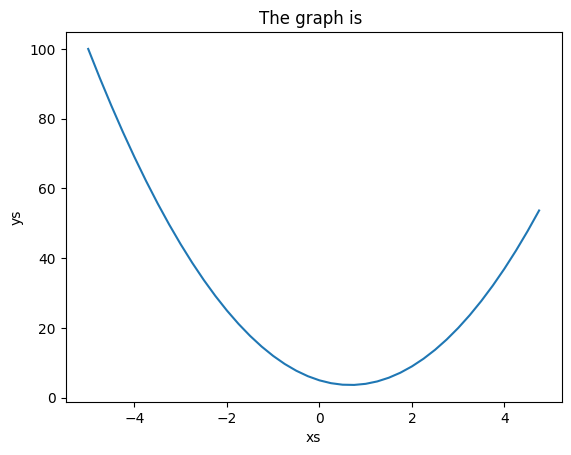

In [4]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)
plt.xlabel('xs')
plt.ylabel('ys')
plt.title('The graph is ')

In [5]:
h=0.0001
x=5
f(x+h)/f(h)

12.00148005239531

In [6]:
h=0.0001
a=1
b=-2
c=4
d1=a*b+c
a+=h
d2=a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/f(h))

d1 2
d2 1.9998
slope -4.0003200015977674e-05


In [7]:
import os
graphviz_path = r'C:\Program Files\Graphviz\bin'  # Modify with the correct path on your system
os.environ["PATH"] += os.pathsep + graphviz_path

In [8]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): 
    return self * other

  def __truediv__(self, other): 
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other): 
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [9]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [10]:
# draw_dot(L)
# L.backward()

In [11]:
# draw_dot(L)

In [12]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  c.data+=h
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-1.9999999999988916


In [13]:
# L=d*f
# dL/dd=f=-2
# dL/df=d=4
# dL/dc=dL/dd * dd/dc=-2.0*1.0=-2.0
# dL/de=dL/de * de/dc=-2.0*1.0=-2.0
# dL/da=dL/dc*dc/da=-2.0*-3.0=6.0
# dL/db=dL/dc*dc/db=-2.0*2.0=-4.0



In [14]:
# L.grad=-8.0
# d.grad=-2
# f.grad=4
# c.grad=-2.0
# d.grad=-2.0
# a.grad=6.0
# b.grad=-4.0

In [15]:
# draw_dot(L)

In [16]:
# a.data+=0.01*a.grad
# b.data+=0.01*b.grad
# c.data+=0.01*c.grad

# e=a*b
# d=c+e
# L=d*f
# print(L)

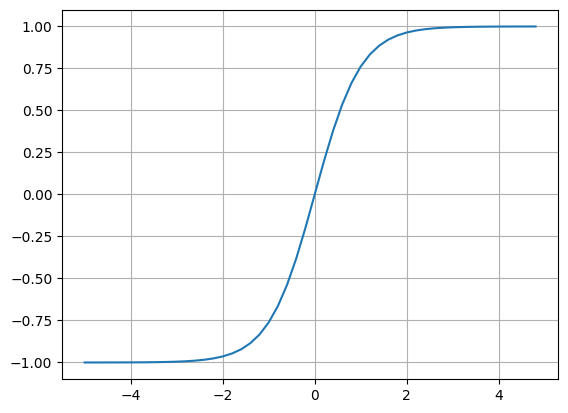

In [17]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [18]:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

In [19]:
draw_dot(n)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [20]:
# o.grad=1.0
# n.grad=0.5
# b.grad=0.5
# x1w1x2w2.grad=0.5
# x1w1.grad=0.5
# x2w2.grad=0.5
# w1.grad=1
# x1.grad=-1.5
# w2.grad=0
# x2.grad=0.5



In [21]:
o.grad=1.0

In [22]:
n._backward()

In [23]:
b._backward()

In [24]:
x1w1x2w2._backward()

In [25]:
x1w1._backward()

In [26]:
x2w2._backward()

In [27]:
x1._backward()

In [28]:
w1._backward()

In [29]:
x2._backward()

In [30]:
w2._backward()

In [31]:
o.backward()
draw_dot(o)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [32]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [33]:
draw_dot(o)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [34]:

a=Value(3.0,label='a')
c=a+a;c.label='c'
c.backward()
draw_dot(c)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [35]:
a=Value(3.0,label='a')
b=Value(-2.0,label='b')
c=a*b; c.label='c'
d=a+b; d.label='d'
e=c*d; e.label='e'
e.backward()
draw_dot(e)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [36]:
a=Value(4.0)
a+1

Value(data=5.0)

In [37]:
a=Value(5.0)
a*2

Value(data=10.0)

In [38]:
a=Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [39]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e=(2*n).exp();e.label='e'
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [40]:
import torch

In [41]:
torch.Tensor([[1,2,3],[4,5,6]])


tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [42]:
x1=torch.Tensor([2.0]).double()  ; x1.requires_grad=True
x2=torch.Tensor([0.0]).double()  ; x2.requires_grad=True
w1=torch.Tensor([-3.0]).double() ; w1.requires_grad=True
w2=torch.Tensor([1.0]).double()  ; w2.requires_grad=True
b=torch.Tensor([6.7]).double()  ; b.requires_grad=True
n=w1*x1 + x2*w2 + b
o=torch.tanh(n)
o.data.item()
o.backward()
print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())

x1 -1.9042192089612318
x2 0.6347397363204106
w1 1.2694794726408212
w2 0.0


In [43]:
# n=Layer(3,4)
# n(x)

In [44]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [45]:
import random

In [46]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7379230591555506)

In [47]:
len(n.parameters())

41

In [48]:
len(n.parameters())

41

In [49]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [0.5, -0.4, -0.6, 0.4] 

In [50]:
ypred=[n(x)]

In [51]:
for k in range(20):
  
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 3.2585218070731856
1 1.716420355745714
2 0.8815872065986661
3 0.6141232778021088
4 0.7796254956559645
5 1.445270975026983
6 1.601280952287545
7 0.8524491149322524
8 0.9875800437536466
9 0.38601574256401405
10 0.16594230496466894
11 0.042288909842757294
12 0.005764269043350738
13 0.0010553657672873339
14 0.0004943142648021448
15 0.0004528234112448488
16 0.0004955876062192237
17 0.0005974229954957888
18 0.0007225070052750023
19 0.0009186682529911872
